In [11]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import arviz as az
import pandas as pd

from simulation.lln import (
    simulate_rv_convergence, plot_rv_convergence
)

az.style.use("arviz-viridish")

In [4]:
res = simulate_rv_convergence(
    dist = "poisson", 
    n = int(1e5), 
    parameters = {"lam": 4.5}
)
res.keys()

dict_keys(['partial_average', 'sample_sizes', 'mse', 'variance', 'parameter'])

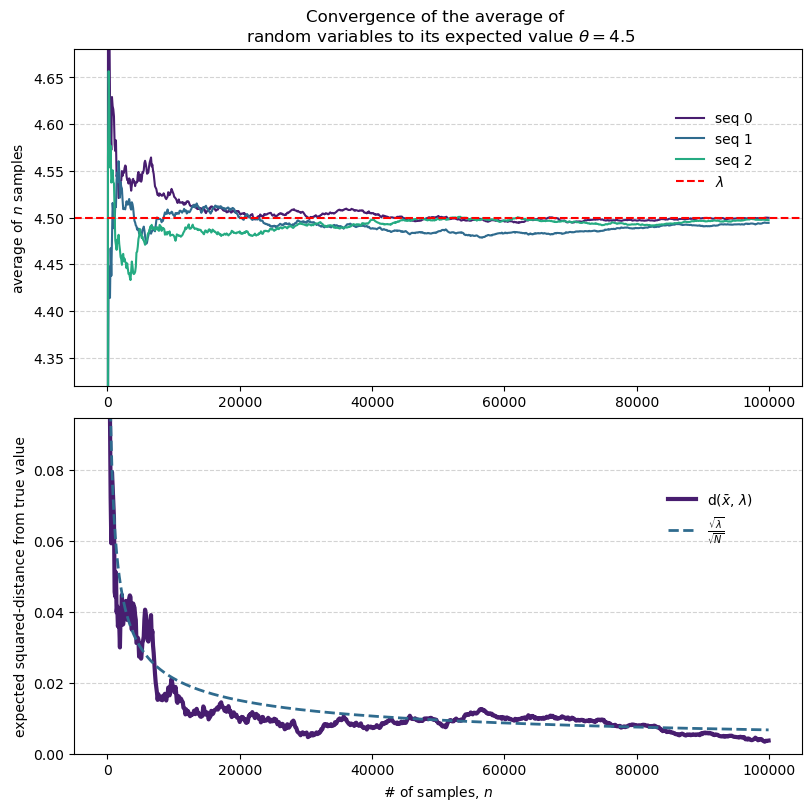

In [5]:
plot_rv_convergence(res)

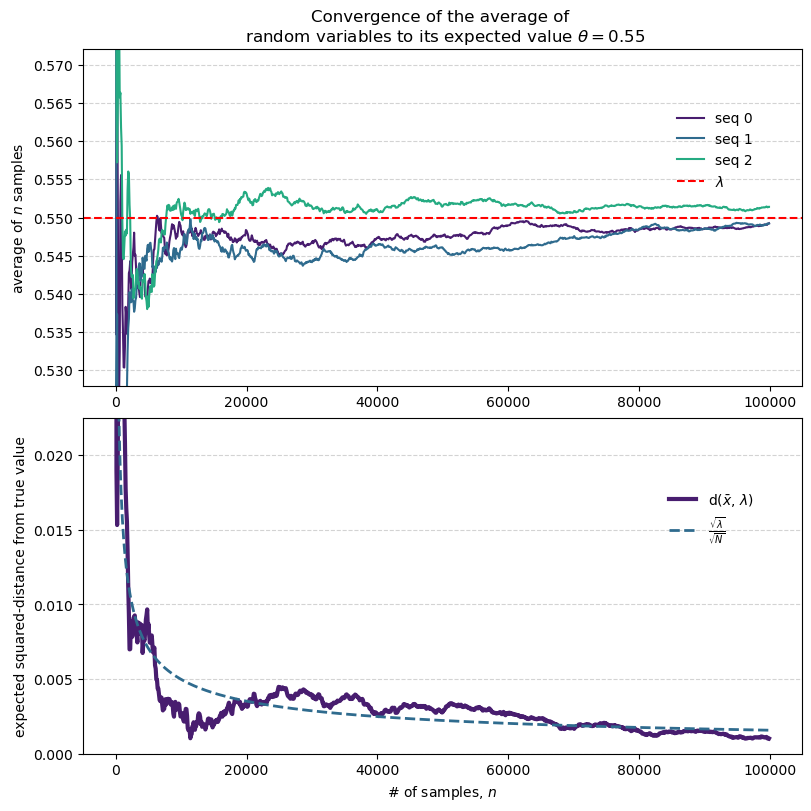

In [6]:
res_bern = simulate_rv_convergence(
    dist = "binomial", 
    n = int(1e5), 
    parameters = {"p": 0.55, "n": 1}
)
plot_rv_convergence(res_bern)

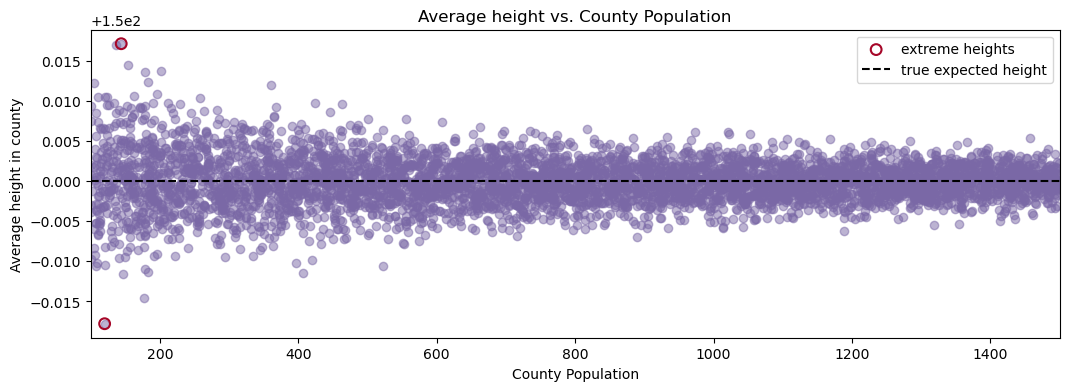

In [8]:
figsize( 12.5, 4) 
std_height = 15
mean_height = 150

n_counties = 5000
pop_generator = np.random.randint
norm = np.random.normal

#generate some artificial population numbers
population = pop_generator(100, 1500, n_counties )

average_across_county = np.zeros( n_counties )
for i in range( n_counties ):
    #generate some individuals and take the mean
    average_across_county[i] = norm(mean_height, 1./std_height,
                                        population[i] ).mean()
    
#located the counties with the apparently most extreme average heights.
i_min = np.argmin( average_across_county )
i_max = np.argmax( average_across_county )

#plot population size vs. recorded average
plt.scatter( population, average_across_county, alpha = 0.5, c="#7A68A6")
plt.scatter( [ population[i_min], population[i_max] ], 
           [average_across_county[i_min], average_across_county[i_max] ],
           s = 60, marker = "o", facecolors = "none",
           edgecolors = "#A60628", linewidths = 1.5, 
            label="extreme heights")

plt.xlim( 100, 1500 )
plt.title( "Average height vs. County Population")
plt.xlabel("County Population")
plt.ylabel("Average height in county")
plt.plot( [100, 1500], [150, 150], color = "k", label = "true expected \
height", ls="--" )
plt.legend(scatterpoints = 1);

In [9]:
print("Population sizes of 10 'shortest' counties: ")
print(population[ np.argsort( average_across_county )[:10] ], '\n')
print("Population sizes of 10 'tallest' counties: ")
print(population[ np.argsort( -average_across_county )[:10] ])

Population sizes of 10 'shortest' counties: 
[120 177 146 407 183 179 522 108 120 397] 

Population sizes of 10 'tallest' counties: 
[144 137 154 201 179 183 104 361 196 163]


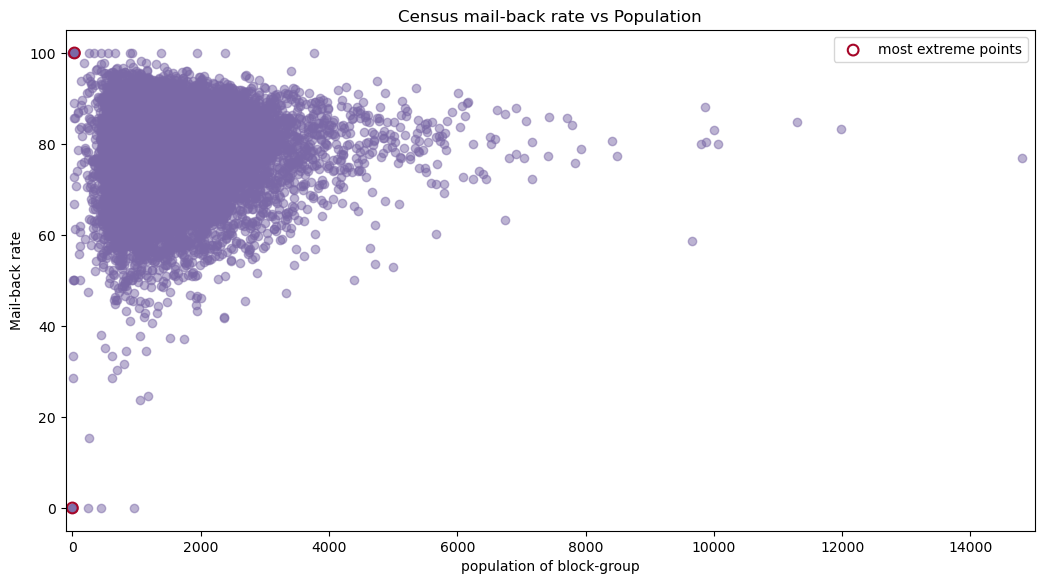

In [10]:
figsize( 12.5, 6.5 )
data = np.genfromtxt( "./data/census_data.csv", skip_header=1, 
                        delimiter= ",")
plt.scatter( data[:,1], data[:,0], alpha = 0.5, c="#7A68A6")
plt.title("Census mail-back rate vs Population")
plt.ylabel("Mail-back rate")
plt.xlabel("population of block-group")
plt.xlim(-100, 15e3 )
plt.ylim( -5, 105)

i_min = np.argmin(  data[:,0] )
i_max = np.argmax(  data[:,0] )
 
plt.scatter( [ data[i_min,1], data[i_max, 1] ], 
             [ data[i_min,0],  data[i_max,0] ],
             s = 60, marker = "o", facecolors = "none",
             edgecolors = "#A60628", linewidths = 1.5, 
             label="most extreme points")

plt.legend(scatterpoints = 1);

In [12]:
df = pd.read_csv("./data/enem_scores.csv")
df.sort_values(by="avg_score", ascending=False).head(10)

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
16668,2005,33062633,59,81.89
16794,2005,33065403,177,81.66
10043,2007,29342880,43,80.32
18121,2007,33152314,14,79.82
16781,2007,33065250,80,79.67
3026,2007,22025740,144,79.52
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


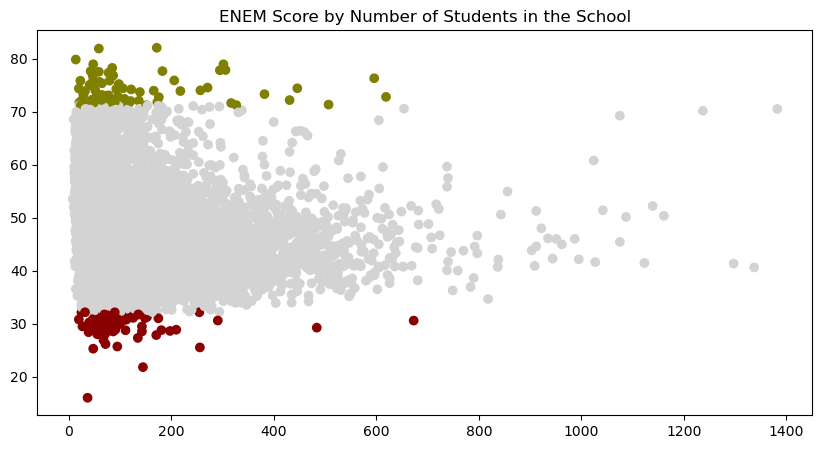

In [19]:
q_99 = np.quantile(df["avg_score"], .99)
q_01 = np.quantile(df["avg_score"], .01)

plot_data = (df
    .sample(10000)
    .assign(Group = lambda d: np.select(
            [d["avg_score"] > q_99, d["avg_score"] < q_01],
            ["Top", "Bottom"], "Middle")
        )
    )
plt.figure(figsize=(10,5))
plt.scatter(
    y=plot_data["avg_score"], 
    x=plot_data["number_of_students"], 
    c=plot_data["Group"].map({"Middle": "lightgrey", "Bottom": "darkred", "Top": "olive"}),
)
plt.title("ENEM Score by Number of Students in the School");

In [99]:
from dotenv import load_dotenv
import os

load_dotenv("reddit.env")

In [102]:
import praw

reddit = praw.Reddit(
    client_id=os.environ.get("client_id"),
    client_secret=os.environ.get("client_secret"),
    user_agent=os.environ.get("user_agent"),
)

top_submissions = reddit.subreddit("Stoicism")
hot_cogsci = top_submissions.new(limit=100)

In [103]:
list_submissions = []
for sub in hot_cogsci:
    if not sub.stickied:
        list_submissions.append({
            "title": sub.title,
            "ups": sub.ups,
            "downs": sub.downs,
            "visited": sub.visited
        })

In [104]:
df_submissions = pd.DataFrame(list_submissions)
df_submissions.head()

,title,ups,downs,visited
0,illness anxiety,1,0,False
1,Why do we have to let go of desires and attach...,1,0,False
2,What exactly is in our control and what is not?,3,0,False
3,Stoic historical sites to visit in Greece?,2,0,False
4,My Job Requires me to waste like 4 hours per d...,1,0,False


In [105]:
def intervals(u,d):
    a = 1. + u
    b = 1. + d
    mu = a/(a+b)
    std_err = 1.65*np.sqrt( (a*b)/( (a+b)**2*(a+b+1.) ) )
    return ( mu, std_err )


print("Approximate lower bounds:")
posterior_mean, std_err  = intervals(df_submissions["ups"], df_submissions["downs"])
lb = posterior_mean - std_err

Approximate lower bounds:


In [110]:
df = df_submissions.assign(
    post_mean = posterior_mean,
    std_err = std_err,
    lb = lb,
).sort_values(by="lb", ascending=False).head(40)


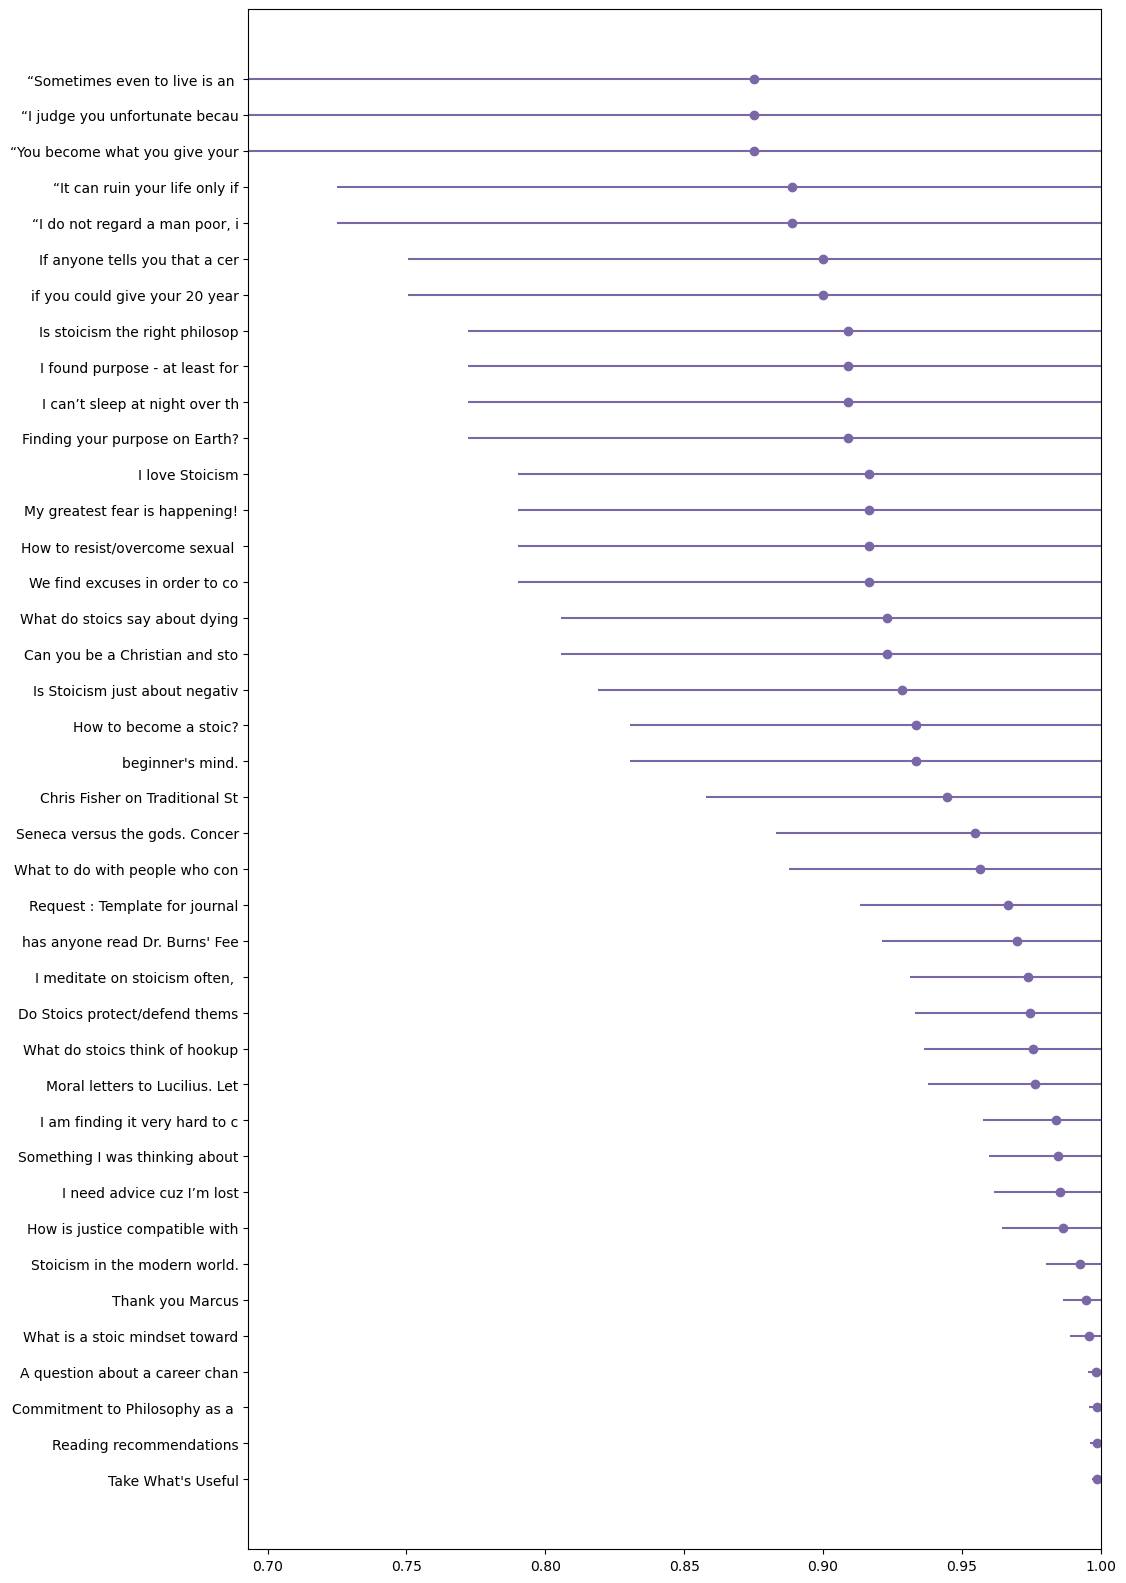

In [111]:
figsize(11, 20)
plt.errorbar( df["post_mean"], np.arange(len(df)), 
               xerr=df["std_err"], capsize=0, fmt="o",
                color = "#7A68A6")
plt.xlim( df["lb"].min(), 1)
plt.yticks( np.arange( len(df) - 1,-1,-1 ), map( lambda x: x[:30].replace("\n",""), df["title"]) );
